# Import Dataset and Libraries

In [1]:
# Standarc library imports
from collections import defaultdict
from random import randrange
from tqdm import tqdm
from typing import Any
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, hamming_loss, jaccard_score,
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

DO_OPTIMIZATION = False
RANDOM_STATE = 42
TEST_SIZE = 0.2
ROYALBLUE = "#4169E1"

In [2]:
warnings.filterwarnings(action='ignore')    # 주피터 노트북 에러 로그 무시하는 코드
plt.rc('font', family='Malgun Gothic')      # plt로 한글 폰트 사용하는 코드

In [29]:
STD_PATH = "."
TRAIN_FILE = f"{STD_PATH}/train.csv"
TEST_FILE = f"{STD_PATH}/test.csv"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

is_pregnant = df_train.columns[-1]
X, y = df_train.drop(is_pregnant, axis=1), df_train[is_pregnant]
X_test = df_test.drop(is_pregnant, axis=1) if is_pregnant in df_test else df_test.copy()

# EDA

In [4]:
def draw_imbalance_barplot(df: pd.DataFrame, title: str, width: int=10, height: int=2) -> None:
    df[title].value_counts().plot.bar(
        color='royalblue',
        figsize = (width, height),
    )    
    plt.title(title)
    plt.xlabel(f"{title} 컬럼의 데이터 종류")
    plt.ylabel('데이터 개수')
    plt.grid(True, linestyle='--', linewidth=0.3, axis='y')
    return

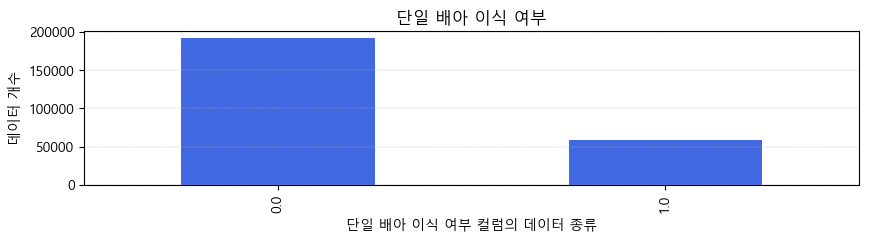

In [5]:
# 테스트용 그래프 그리기(무작위 컬럼)
random_column = X.columns.tolist()[randrange(1, len(X.columns.tolist()))]
draw_imbalance_barplot(X, random_column)

In [6]:
def draw_heatmap(df: pd.DataFrame, method: str='pearson', width: int=8, height: int=8) -> None:
    # method: pearson(default), kendall, spearman
    # interpolation: None(default), nearest, bilinear, bicubic, gaussian, hanning, hamming, lanczos, none
    
    corr_matrix = df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))    
    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
    return

In [7]:
# # 테스트용 그래프 그리기
# draw_heatmap(X, width=50, height=50)

In [8]:
# X.info()
float64_columns = X.select_dtypes(include='float64').columns.tolist()
int64_columns = X.select_dtypes(include='int64').columns.tolist()
object_columns = X.select_dtypes(include='O').columns.tolist()

# Data Preprocessing

### 1. Feature Cleaning

In [9]:
# """
# - Missing values(drop, mean, median, mode, KNNImputer, MICE)
# - Outliers (IQR, log)
# - Feature selection(remove duplicates, VIF)
# """

In [10]:
values = {
    **{column: 0 for column in float64_columns},
    **{column: 0 for column in int64_columns},
    **{column: "0" for column in object_columns}
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

### 2. Feature Engineering

In [11]:
# """
# - Feature Creation
# - Feature Transformation(log, sqrt, min-max scaling)
# - Feature Extraction(PCA, LDA, heatmap)
# """

### 3. Feature Encoding

In [12]:
# """
# - LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
# """

In [13]:
encoder = OrdinalEncoder()

X[object_columns] = encoder.fit_transform(X[object_columns])
X_test[object_columns] = encoder.fit_transform(X_test[object_columns])

### 4. Feature Removal

In [14]:
# 주석이 달린 컬럼만 모델 학습에 사
drop_features = [
     'ID',
     '시술 시기 코드',
     # '시술 당시 나이',
     '임신 시도 또는 마지막 임신 경과 연수',
     '시술 유형',
     '특정 시술 유형',
     '배란 자극 여부',
     '배란 유도 유형',
     '단일 배아 이식 여부',
     '착상 전 유전 검사 사용 여부',
     '착상 전 유전 진단 사용 여부',
     '남성 주 불임 원인',
     '남성 부 불임 원인',
     '여성 주 불임 원인',
     '여성 부 불임 원인',
     '부부 주 불임 원인',
     '부부 부 불임 원인',
     '불명확 불임 원인',
     '불임 원인 - 난관 질환',
     '불임 원인 - 남성 요인',
     '불임 원인 - 배란 장애',
     '불임 원인 - 여성 요인',
     '불임 원인 - 자궁경부 문제',
     '불임 원인 - 자궁내막증',
     '불임 원인 - 정자 농도',
     '불임 원인 - 정자 면역학적 요인',
     '불임 원인 - 정자 운동성',
     '불임 원인 - 정자 형태',
     '배아 생성 주요 이유',
     '총 시술 횟수',
     '클리닉 내 총 시술 횟수',
     'IVF 시술 횟수',
     'DI 시술 횟수',
     '총 임신 횟수',
     'IVF 임신 횟수',
     'DI 임신 횟수',
     '총 출산 횟수',
     'IVF 출산 횟수',
     'DI 출산 횟수',
     # '총 생성 배아 수',
     '미세주입된 난자 수',
     '미세주입에서 생성된 배아 수',
     # '이식된 배아 수',
     '미세주입 배아 이식 수',
     # '저장된 배아 수',
     '미세주입 후 저장된 배아 수',
     '해동된 배아 수',
     '해동 난자 수',
     '수집된 신선 난자 수',
     '저장된 신선 난자 수',
     '혼합된 난자 수',
     '파트너 정자와 혼합된 난자 수',
     '기증자 정자와 혼합된 난자 수',
     # '난자 출처',
     '정자 출처',
     '난자 기증자 나이',
     '정자 기증자 나이',
     '동결 배아 사용 여부',
     '신선 배아 사용 여부',
     '기증 배아 사용 여부',
     '대리모 여부',
     'PGD 시술 여부',
     'PGS 시술 여부',
     '난자 채취 경과일',
     '난자 해동 경과일',
     '난자 혼합 경과일',
     # '배아 이식 경과일',
     '배아 해동 경과일'
]

X = X.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

# Hyperparameter Tuning

In [15]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C

In [16]:
def optimize() -> None:
    return


if DO_OPTIMIZATION:
    optimize()

# Modeling

### 1. Import

In [17]:
# Model imports
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [18]:
clf_model_dict = {
    "adaboost": AdaBoostClassifier(),
    "gradient": GradientBoostingClassifier(),
    "random_forest": RandomForestClassifier(),
    "lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "svc": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier(),
    "catboost": CatBoostClassifier(verbose=False),
    "lgbm": LGBMClassifier(),
    "xgb": XGBClassifier(),
}

### 2. Training

In [19]:
def eval(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    # is CatBoostClassifier
    if isinstance(y_pred[0], str):
        accuracy = accuracy_score(y, y_pred)                        # 정확도
        precision = precision_score(y, y_pred, pos_label='True')    # 정밀도
        recall = recall_score(y, y_pred, pos_label='True')          # 재현율
        f1 = f1_score(y, y_pred, pos_label='True')                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)                         # ROC-AUC 점수
        
    else:
        accuracy = accuracy_score(y, y_pred)      # 정확도
        precision = precision_score(y, y_pred)    # 정밀도
        recall = recall_score(y, y_pred)          # 재현율
        f1 = f1_score(y, y_pred)                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

### 3. Select Model

In [20]:
model_name = "catboost"
model = clf_model_dict[model_name]

### 4. K-Fold Cross Validation

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = []
score_types = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[test_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    scores = eval(model, X_val, y_val)
    roc_auc_scores.append(scores[-1])

    for score_type, score in zip(score_types, scores):
        print(f"{score_type} (Fold {idx}): {score}")
    print()

print(f"Cross-Validation Average ROC-AUC Score: {np.mean(roc_auc_scores)}")

Accuracy (Fold 0): 0.7446899806908389
Precision (Fold 0): 0.5279369627507163
Recall (Fold 0): 0.11127887664200513
F1-Score (Fold 0): 0.18381344307270234
ROC-AUC (Fold 0): 0.7302875789081205

Accuracy (Fold 1): 0.7426175151160522
Precision (Fold 1): 0.5084922010398614
Recall (Fold 1): 0.11075877689694225
F1-Score (Fold 1): 0.1818970861748295
ROC-AUC (Fold 1): 0.7332084259401971

Accuracy (Fold 2): 0.7429490930368636
Precision (Fold 2): 0.5113168724279835
Recall (Fold 2): 0.11257078142695356
F1-Score (Fold 2): 0.18451828475960647
ROC-AUC (Fold 2): 0.731533982654812

Accuracy (Fold 3): 0.7433391847084064
Precision (Fold 3): 0.5143611753053813
Recall (Fold 3): 0.11762041370979918
F1-Score (Fold 3): 0.19145929339477727
ROC-AUC (Fold 3): 0.7309398791465542

Accuracy (Fold 4): 0.7440803588843378
Precision (Fold 4): 0.5225713253882268
Recall (Fold 4): 0.10924052544164276
F1-Score (Fold 4): 0.18070558851077115
ROC-AUC (Fold 4): 0.7326093677764617

Cross-Validation Average ROC-AUC Score: 0.73171

# Visualization

### 1. Using Seaborn

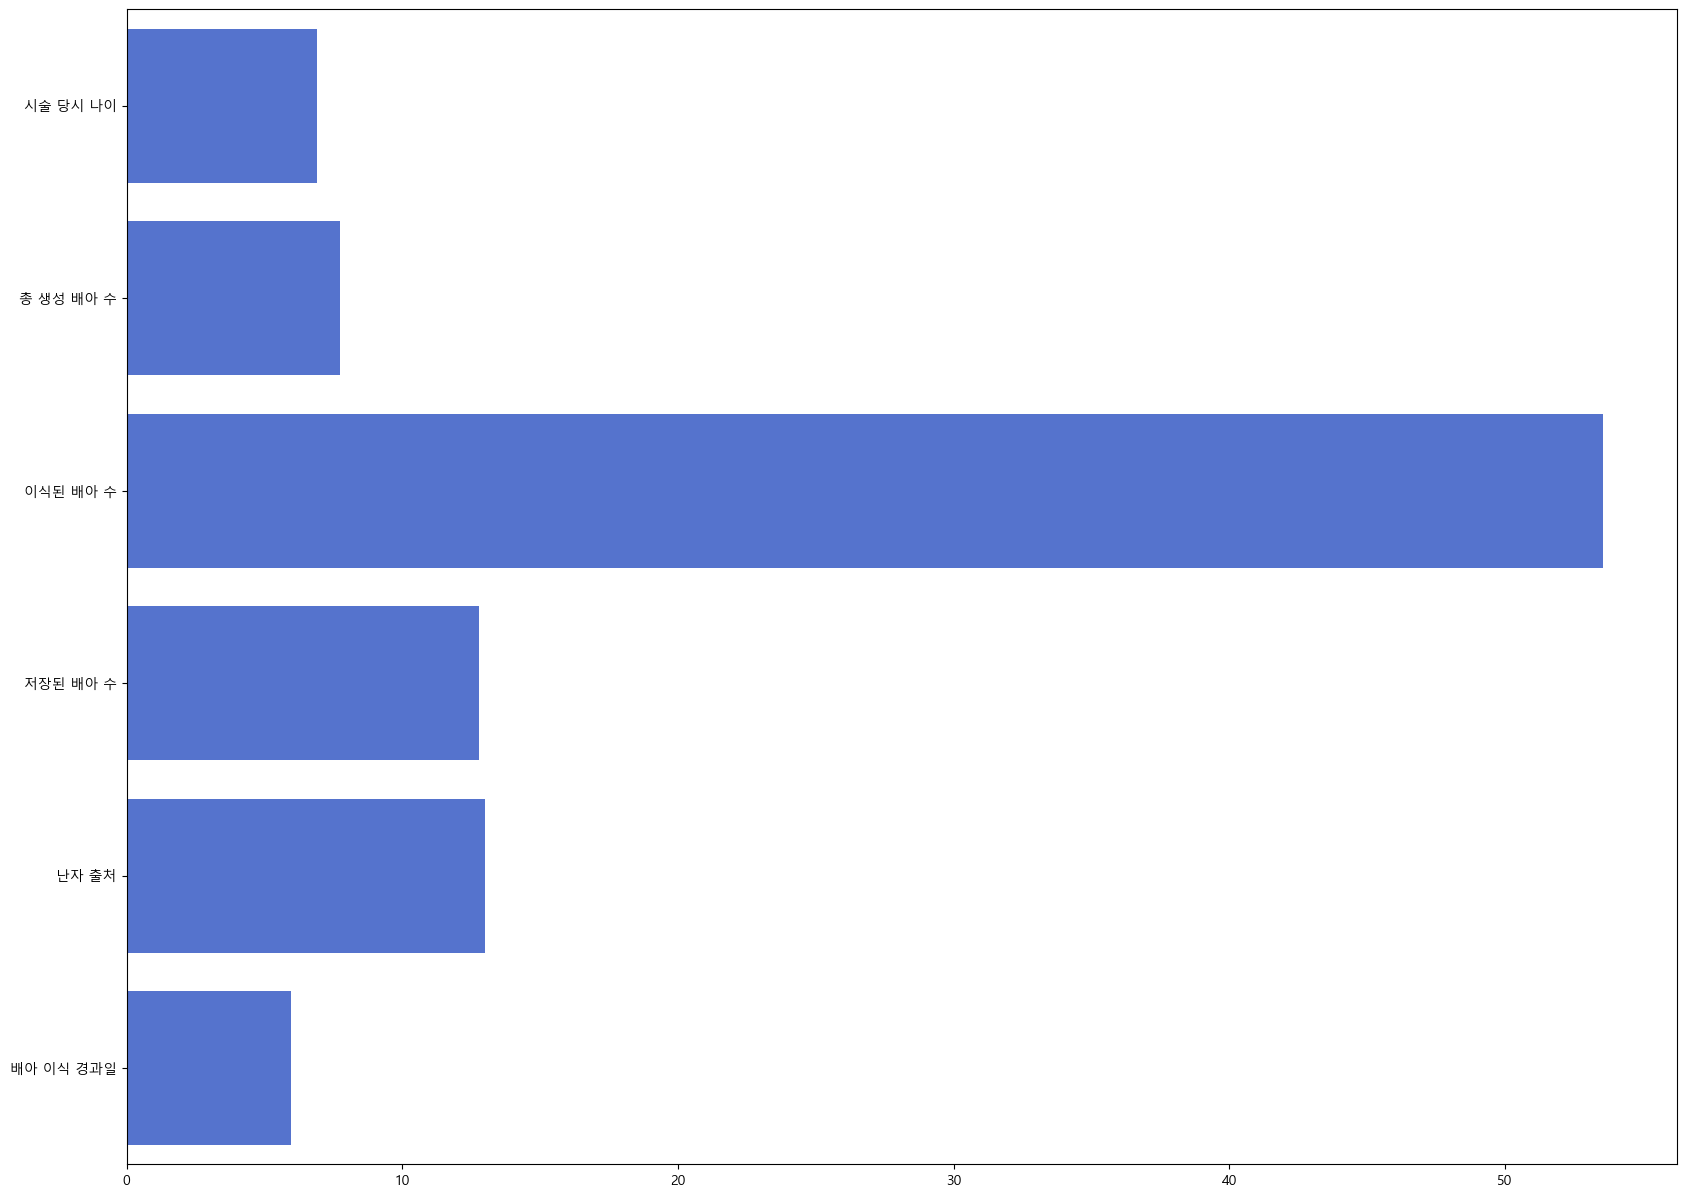

In [22]:
feature_names = X.columns.tolist()
plt.figure(figsize=(20,15))
if isinstance(model, LogisticRegression):
    sns.barplot(x=model.coef_[0], y=feature_names, palette=[ROYALBLUE])
else:
    sns.barplot(x=model.feature_importances_, y=feature_names, palette=[ROYALBLUE])

### 2. DESC Feature Importances

In [23]:
importances = (
    sorted(enumerate(model.coef_[0]), key=lambda x: x[1], reverse=True)[:5]
    if isinstance(model, LogisticRegression)
    else sorted(enumerate(model.feature_importances_), key=lambda x: x[1], reverse=True)[:5]
)

for idx, (col, score) in enumerate(importances, 1):
    print(f"{idx}. {X.columns.tolist()[col]} ({score:.2f})")

1. 이식된 배아 수 (53.55)
2. 난자 출처 (13.02)
3. 저장된 배아 수 (12.79)
4. 총 생성 배아 수 (7.76)
5. 시술 당시 나이 (6.89)


# Create Submission

In [24]:
# Final Submission
model.fit(X, y)
prediction = model.predict(X_test)
df_submission = pd.DataFrame({'ID': df_test['ID'], 'probability': prediction})
df_submission.to_csv("submission.csv", index=False)
df_submission['probability'].value_counts()

probability
0    84970
1     5097
Name: count, dtype: int64